In [ ]:
## adapted from https://github.com/brainlife/app-tractanalysisprofiles/blob/dipy-1.0/tractAnalysisProfilesDipy.py

In [29]:
%matplotlib notebook

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt

In [44]:

import sklearn
import dipy
import nibabel as nib
import scipy.io as sio
from dipy.io.streamline import load_tractogram, save_tractogram
import dipy.tracking.streamline as dts
import dipy.stats.analysis as dsa
from dipy.segment.clustering import QuickBundles
from dipy.segment.metric import AveragePointwiseEuclideanMetric
## udpated in dipy 1.5.0: https://dipy.org/documentation/1.7.0/api_changes/
from dipy.segment.featurespeed import ResampleFeature

In [3]:
datadir = "/media/storage/HCP_subjects"
subject = "sub-100206"
n_points = 100

# pipeline components

## load data

In [4]:
def generateRAScentroid(centroid_cluster):

	import numpy as np

	[x_diff, y_diff, z_diff] = np.diff([centroid_cluster[:,0],centroid_cluster[:,1],centroid_cluster[:,2]])
	[x_diff, y_diff, z_diff] = [np.append(x_diff,[centroid_cluster[0,0] - centroid_cluster[-1,0]]),np.append(y_diff,[centroid_cluster[0,1] - centroid_cluster[-1,1]]),np.append(z_diff,[centroid_cluster[0,2] - centroid_cluster[-1,2]])]
	[x_diff_max, y_diff_max, z_diff_max] = [np.max(np.absolute(x_diff)),np.max(np.absolute(y_diff)),np.max(np.absolute(z_diff))]

	max_dim = np.where([x_diff_max,y_diff_max,z_diff_max] == np.max([x_diff_max,y_diff_max,z_diff_max]))[0][0]

	if centroid_cluster[0,max_dim] < centroid_cluster[-1,max_dim]:
		centroid_cluster = np.flip(centroid_cluster,0)

	return centroid_cluster

In [5]:
# https://github.com/brainlife/app-tractanalysisprofiles/blob/dipy-1.0/tractAnalysisProfilesDipy.py#L3-L16
reference_anat_path = os.path.join(datadir, subject, "dwi", "dwi.nii.gz")
streamlines_path = os.path.join(datadir, subject, "track-tck_lmax-8", "track.tck")
classification_path = os.path.join(datadir, subject, "wmc_cleaned-SD3", "classification.mat")

# load reference anatomy (dwi)
print('loading reference anatomy')
ref_anat = nib.load(reference_anat_path)

# load tractogram
print('loading tractogram')
streamlines = load_tractogram(streamlines_path,ref_anat)

# load classification
print('loading classification')
classification = sio.loadmat(classification_path)

# extract names and indices from classification
names = list(np.ravel(list(classification['classification'][0]['names'][0][0])))
## indicator var for which of the 3000000 streamlines belong to which tract
indices = classification['classification'][0]['index'][0][0]

loading reference anatomy
loading tractogram
loading classification


In [6]:

# define metrics to use for reorienting streamlines using quickbundles 
feature = ResampleFeature(nb_points=n_points)
metric = AveragePointwiseEuclideanMetric(feature)

## reorient

In [7]:
## FIXME: for loop starts here

tn = "rightUncinate"
tii = np.where(np.array(names)==tn)[0][0]
tn, tii

('rightUncinate', 8)

In [8]:
# extract streamline data from classificaiton and input streamlines
## tract inds start from 1
tract_indices = np.where(indices==(tii+1))[0]
fg = streamlines.streamlines[tract_indices]

In [9]:
len(fg)

1642

In [10]:
# reorient streamlines to match orientation of first streamline. then compute centroid
fg_oriented = dts.orient_by_streamline(fg,fg[0])

In [11]:

# run quickbundles, find centroid, and reorient streamlines
qb = QuickBundles(np.inf,metric=metric)
tract_cluster = qb.cluster(fg_oriented)
centroid_cluster = tract_cluster.centroids[0]

In [12]:

centroid_cluster_ras = generateRAScentroid(centroid_cluster)
oriented_tract = dts.orient_by_streamline(fg,centroid_cluster_ras)

## save to orignal format

In [39]:
from dipy.io.stateful_tractogram import StatefulTractogram

In [32]:
from copy import deepcopy as dc

In [41]:
streamlines.space

<Space.RASMM: 'rasmm'>

In [43]:
newsts = StatefulTractogram(oriented_tract, space=streamlines.space, reference=ref_anat)

In [46]:

streamlines_outpath = os.path.join(datadir, subject, "track-tck_lmax-8_reorient", "track.tck")
save_tractogram(newsts, streamlines_outpath)

True

# vis

<IPython.core.display.Javascript object>


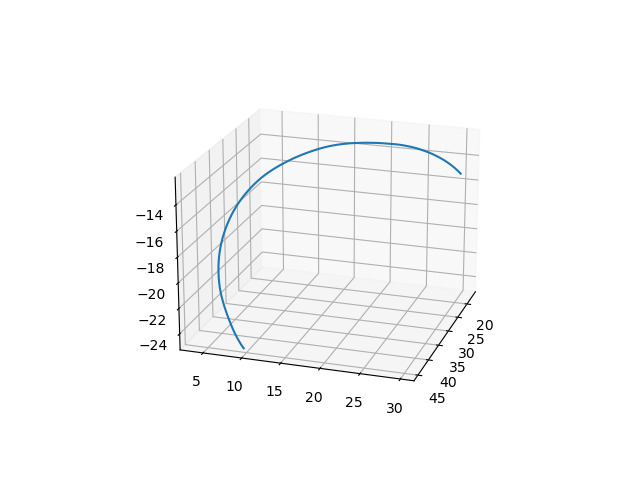

In [44]:
ax = plt.figure().add_subplot(projection='3d')
x, y, z = centroid_cluster.T
ax.plot(x,y,z)

<IPython.core.display.Javascript object>


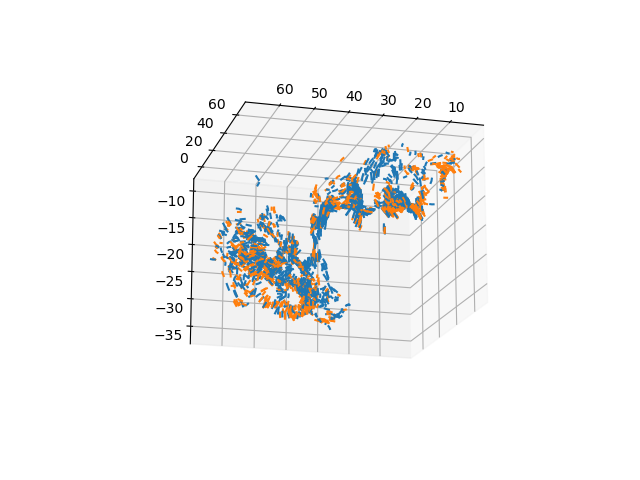

In [113]:

ax = plt.figure().add_subplot(projection='3d')
for ff in fg:
    x, y, z = ff[:3].T
    ax.plot(x,y,z, c="C0")
    
    x, y, z = ff[-3:].T
    ax.plot(x,y,z, c="C1")

<IPython.core.display.Javascript object>


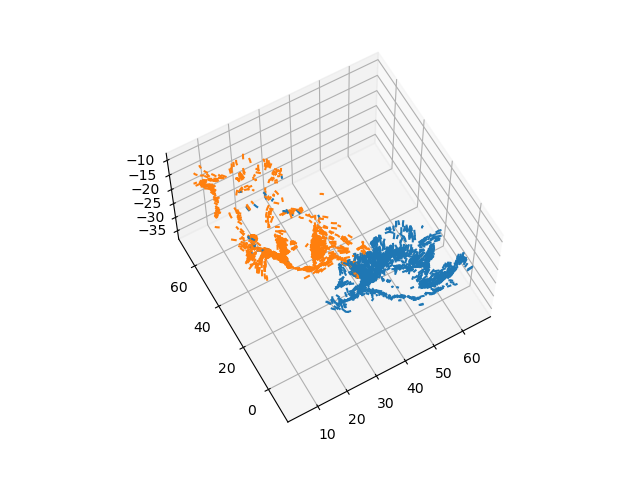

In [110]:

ax = plt.figure().add_subplot(projection='3d')
for ff in fg_oriented:
    x, y, z = ff[:3].T
    ax.plot(x,y,z, c="C0")
    
    x, y, z = ff[-3:].T
    ax.plot(x,y,z, c="C1")

<IPython.core.display.Javascript object>


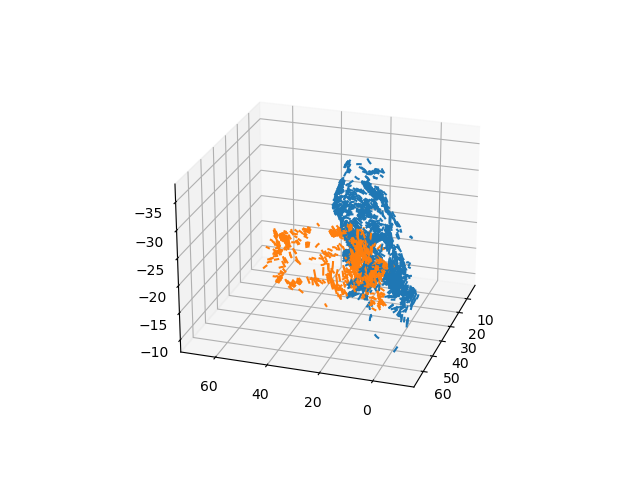

In [109]:

ax = plt.figure().add_subplot(projection='3d')
for ff in oriented_tract:
    x, y, z = ff[:3].T
    ax.plot(x,y,z, c="C0")
    
    x, y, z = ff[-3:].T
    ax.plot(x,y,z, c="C1")

# fix
* get all endpoints, kmeans cluster
* get center of clusters --> RAS/LPI

* dumb problem: clustering may classify two ends of the same streamline in the same cluster.
* solution: 
    * for semconn: use current tract profile implementation to solve semconn problem;
    * for BL: remove troublesome streamlines?

In [119]:
from sklearn.cluster import KMeans

In [116]:
oriented_tract[0].shape

(82, 3)

In [125]:
## get streamline end coords for both ends
end1 = np.stack([line[0] for line in oriented_tract])
end2 = np.stack([line[-1] for line in oriented_tract])
allends = np.vstack([end1, end2])
allends.shape

(3284, 3)

In [126]:
km = KMeans(n_clusters=2)
clu = km.fit_predict(allends)

/home/sunaguo/miniconda3/envs/wm/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [129]:
newend1, newend2 = np.split(clu, 2)
newend1.shape

(1642,)

In [136]:
st[:3,2]

array([-28.79969 , -28.295757, -27.743732], dtype=float32)

<IPython.core.display.Javascript object>


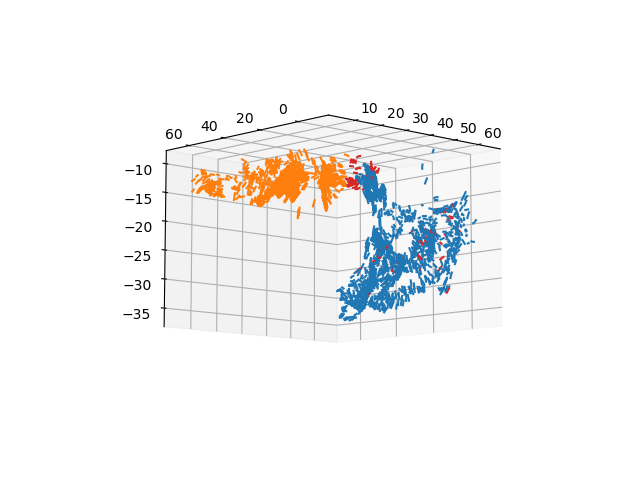

In [140]:


ax = plt.figure().add_subplot(projection='3d')
for sii, (e1, e2) in enumerate(zip(newend1, newend2)):
    c1, c2 = "C0", "C1"
    if e1 == e2: 
        c1=c2 = "C3"
    st = oriented_tract[sii]
    ax.plot(st[:3,0], st[:3,1], st[:3,2], c=c1)
    ax.plot(st[-3:,0], st[-3:,1], st[-3:,2], c=c2)

# [disgard] fix - parcellation based 
* map parcellation (on surface) to volume 
* load parcellation volume here
* check out where/whiwch ROIs the streamlines tend to end 
* make mapping 